# Camera Calibration comparision


In [1]:
import os;
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline

## Data Collection using webcam

In [2]:
def capture_webcam():
    cam = cv2.VideoCapture(0)

    cv2.namedWindow("test")

    img_counter = 0

    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("test", frame)

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            img_name = "webcam_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

    cam.release()

    cv2.destroyAllWindows()

In [3]:
# capture_webcam()

# # Function findobjpts_imgpts()
Find the cornerpoints in chessboard to know the pixel coordinates

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
def findobjpts_imgpts(images,x,y):
    objp = np.zeros((y*x,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (x,y), corners, ret)
            write_name = 'corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
#             cv2.imshow('img', img)
#             cv2.waitKey(500)
#     cv2.destroyAllWindows()
    return objpoints,imgpoints,

## Now find the Projection matrix given image points and world points

## calibrateCamera() Function


Input 

Obj points -- vector of vectors of calibration objpoints (3D space)

imgpoits --- vector of vector of image points (2D space)

image_size 

flags --- for various distortions

criteria for ending the iterative algorithm

Output

ret -- return value / mean reprojection error

mtx -- camera matrix 

dist -- distortion coefficients

rvecs -- output rotation vector of vectors (for each pattern view)

tvecs -- output translation vector of vectors (for each pattern view)

## calibrateCameraExtended() Function

Output:

std_in -- std deviation over intrinsic parameters

std_out -- std deviation over extrinsic parameters

per_view_errors -- Used to analyze the reprojection error per view

In [5]:
#calibrateCamera() on go pro wide images
#takes input images,chessboard gid structue x,y (eg:8x6)
def camcalib(images,objpoints,imgpoints):
    for idx,fname in enumerate(images):
        img=cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret,mtx,dist,rvecs,tvecs
   
#cameracalib_extended on go pro wide images
#used to obtain perview error to remove the image with high reprojection error and calibrate again
def camcalib_extended(images,objpoints,imgpoints):
    for idx,fname in enumerate(images):
        img=cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs,std_in,std_ex,per_view_error = cv2.calibrateCameraExtended(objpoints, imgpoints, img_size,None,None)
    return ret,mtx,dist,rvecs,tvecs,std_in,std_ex,per_view_error

## calibrateCameraRO () function

This function is an extention of calibrateCamera() where the parameters are choosen such that the intrinsic parameters are well optimized

objpts -- Vector of vectors of calibration pattern points in the calibration pattern coordinate space.If the method of releasing object to be used, the identical calibration board must be used in each view and it must be fully visible, and all objectPoint must be the same and all points should be roughly close to a plane. The calibration target has to be rigid, or at least static if the camera (rather than the calibration target) is shifted for grabbing images

newObjpts -- The updated output vector of calibration pattern points. The coordinates might be scaled based on three fixed points. The returned coordinates are accurate only if the above mentioned three fixed points are accurate. If not needed, noArray() can be passed in. This parameter is ignored with standard calibration method

fixpts -- Index of fixed point

## calibrateCameraROExtended() function
This function is similar to calibrateCameraExtended function which yeils

outputs :

stdDeviationsIntrinsics,stdDeviationsExtrinsics, stdDeviationsObjPoints--standard deviations of estimated intrinsic, extrinsic and  newObject points 

perViewErrors -- Reprojection error for each pattern view 

In [6]:
# fixpts = 22
def camcalib_RO(images,objpoints,imgpoints,fixpts):
    for idx,fname in enumerate(images):
        img=cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs,newObjpts = cv2.calibrateCameraRO(objpoints, imgpoints, img_size,fixpts,None,None)
    return ret, mtx, dist, rvecs, tvecs,newObjpts

def camcalib_RO_extended(images,objpoints,imgpoints,fixpts):
    for idx,fname in enumerate(images):
        img=cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs,newObjpts,stdDeviationsIntrinsics,\
        stdDeviationsExtrinsics, stdDeviationsObjPoints,\
        perViewErrors = cv2.calibrateCameraROExtended(objpoints, imgpoints, img_size,fixpts,None,None)
    return ret, mtx, dist, rvecs, tvecs,newObjpts,stdDeviationsIntrinsics,\
           stdDeviationsExtrinsics, stdDeviationsObjPoints,\
           perViewErrors

### Comparision on GoPro wide images


In [10]:
#We directly compare the Extended functions to check perviewerrors
def compare_functions(images,x,y):
    objpoints,imgpoints= findobjpts_imgpts(images,x,y)
    t1=time.time()
    mean_error1,mtx1,dist1,revecs1,tvecs1,std_in,std_ex,perViewErrors_normal= camcalib_extended(images,objpoints,imgpoints)
    t2=time.time()

    print("calibrateCamera() \nExecution time:\t "+str(t2-t1)+"\tRMS Reprojection Error:\t"+str(mean_error1))
    t3=time.time()
    fixpts= 3
    mean_error2,mtx, dist, rvecs, tvecs,newObjpts,\
    stdDeviationsIntrinsics,stdDeviationsExtrinsics,\
    stdDeviationsObjPoints,perViewErrors_RO   = camcalib_RO_extended(images,objpoints,imgpoints,fixpts)
    t4=time.time()
    print("calibrateCamera() \nExecution time:\t "+str(t4-t3)+"\tRMS Reprojection Error:\t"+str(mean_error2))
    ##plot scatter plot of perviewerror 

    patternFrameNo=[i for i in range(1,len(images))]
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(patternFrameNo, perViewErrors_normal, color='r',label='cameraCalibrate()')
    ax.scatter(patternFrameNo, perViewErrors_RO, color='b',label='cameraCalibrateRO()')

    ax.set_xlabel('Frame number')
    ax.set_ylabel('Reprojection Error')
    ax.set_title('scatter plot')
    l=ax.legend()
    plt.show()
    return mean_error1,mean_error2,perViewErrors_normal,perViewErrors_RO






calibrateCamera() 
Execution time:	 30.082420587539673	RMS Reprojection Error:	0.5623861146245458
calibrateCamera() 
Execution time:	 128.0088415145874	RMS Reprojection Error:	0.40660690781163833


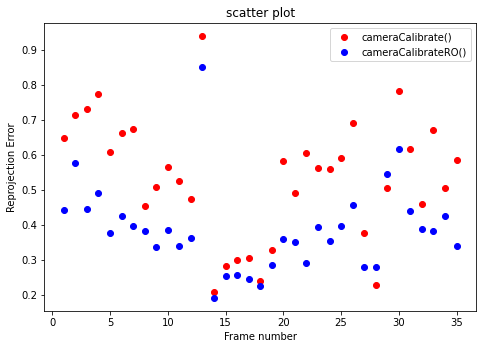

In [13]:
#gopro wide images
images = glob.glob('calibration_wide/GO*.jpg')
x=8  
y=6
err1,err2,perviewerr1,perviewerr2=compare_functions(images,x,y)
#images with Reprojection Error > 0.75


Images with Error > 0.75
So removing these images to recalibrate the camera again


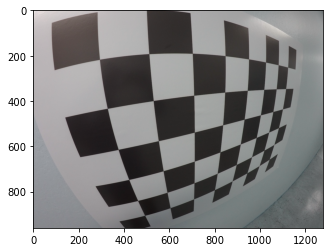

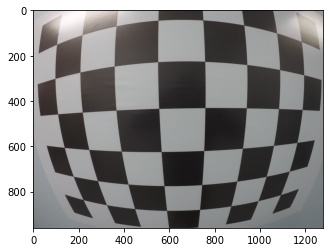

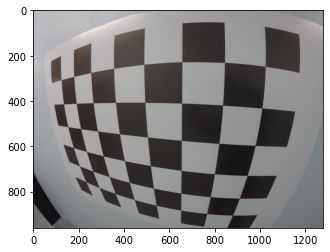

33


In [18]:
image_idx=[idx for idx,val in enumerate(perviewerr1)if val> 0.75 ]
print("Images with Error > 0.75")
print("So removing these images to recalibrate the camera again")
for i in image_idx:
    plt.imshow(cv2.imread(images[i]))
    plt.show()
    images.pop(i)
print(len(images))


### Here the calibration error has reduced by removing the images with high error

calibrateCamera() 
Execution time:	 22.805268049240112	RMS Reprojection Error:	0.4779542991368403
calibrateCamera() 
Execution time:	 112.22146511077881	RMS Reprojection Error:	0.30225679379230486


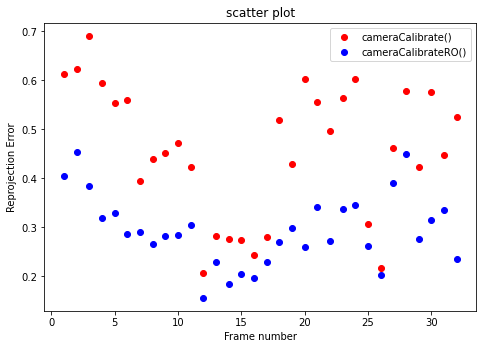

In [19]:
#recalibrating again and comparing
err1,err2,perviewerr1,perviewerr2=compare_functions(images,x,y)

Text(0.5, 1.0, 'Undistorted Image')

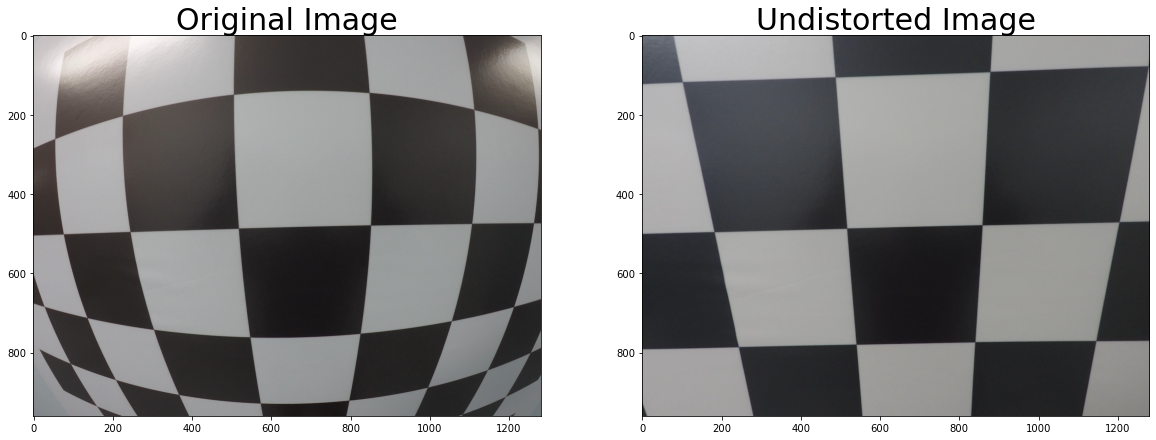

In [20]:

img = cv2.imread('calibration_wide/test_image.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)